### **Train the Loan Default Predictor Model**

<br>

#### **1. Load the necessary libraries and dataset**

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin


from imblearn.pipeline import Pipeline as ImbPipeline  # use ImbPipeline consistently
from imblearn.over_sampling import SMOTE

from category_encoders import TargetEncoder
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import pickle

warnings.filterwarnings("ignore", message="X does not have valid feature names")

In [2]:
# Load datasets
model_data = pd.read_csv("model_data.csv")
model_data.head()

,loannumber,loanamount,totaldue,termdays,bank_account_type,bank_name_clients,employment_status_clients,last_loan_amount,avg_amount,std_amount,...,referred,age,state,acct_age_years,time_btwn_last_loan,default,credit_score,debt_to_loan_ratio,const_default,unusual_large
0,12,30000.0,34500.0,30,Other,Diamond Bank,Permanent,20000.0,18181.82,5749.60,...,0,53.0,Lagos,9,0,0,3.828959,1.1500,0,0
1,2,15000.0,17250.0,30,Savings,GT Bank,Permanent,10000.0,10000.00,0.00,...,0,40.0,Oyo,8,-5,0,4.082298,1.1500,0,0
2,7,20000.0,22250.0,15,Other,EcoBank,Permanent,10000.0,10000.00,0.00,...,0,40.0,Gombe,8,41,0,3.392146,1.1125,0,0
3,3,10000.0,11500.0,15,Savings,First Bank,Permanent,10000.0,10000.00,0.00,...,0,47.0,Oyo,8,13,0,1.002517,1.1500,1,0
4,9,40000.0,44000.0,30,Other,GT Bank,Permanent,30000.0,18750.00,7806.25,...,0,39.0,Federal Capital Territory,9,0,0,4.757969,1.1000,0,1


In [3]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   loannumber                 4368 non-null   int64  
 1   loanamount                 4368 non-null   float64
 2   totaldue                   4368 non-null   float64
 3   termdays                   4368 non-null   int64  
 4   bank_account_type          4368 non-null   object 
 5   bank_name_clients          4368 non-null   object 
 6   employment_status_clients  4368 non-null   object 
 7   last_loan_amount           4368 non-null   float64
 8   avg_amount                 4368 non-null   float64
 9   std_amount                 4368 non-null   float64
 10  avg_total_due              4368 non-null   float64
 11  avg_term_days              4368 non-null   float64
 12  std_term_days              4368 non-null   float64
 13  avg_approval_time          4368 non-null   float

In [4]:
# =========================
# Train/Test Split

# Features & target
X = model_data.drop(columns=["default"])
y = model_data["default"]

# Train-test split (70-30) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train distribution:\n", y_train.value_counts(normalize=True))
print("\nTest distribution:\n", y_test.value_counts(normalize=True))

Train distribution:
 default
0    0.781912
1    0.218088
Name: proportion, dtype: float64

Test distribution:
 default
0    0.782609
1    0.217391
Name: proportion, dtype: float64


In [5]:
# =========================
# Preprocessor

# Identify categorical and numeric features
categorical_features = ["bank_account_type", "bank_name_clients",
                        "employment_status_clients", "state"]
numeric_features = X.drop(columns=categorical_features).columns.tolist()

categorical_transformer = TargetEncoder(cols=categorical_features)
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [6]:
# =========================
# Safe Cluster Transformer: Adds 'risk_level' column by training set clustering based on similarity of profiles


class RiskClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=3, random_state=42, column_name="risk_level"):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.column_name = column_name
        self.kmeans_ = None
        self.cluster_map_ = None

    def fit(self, X, y=None):
        # Convert to numpy for KMeans
        X_np = X.values if hasattr(X, "values") else np.asarray(X)
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        clusters = self.kmeans_.fit_predict(X_np)

        if y is None:
            # No y -> map by cluster index order
            order = np.argsort(np.bincount(clusters))
            self.cluster_map_ = {c: i for i, c in enumerate(order)}
        else:
            # Map cluster -> default prob, then order ascending
            df = pd.DataFrame({"cluster": clusters, "default": np.asarray(y)})
            cluster_risk = df.groupby("cluster")["default"].mean().sort_values()
            self.cluster_map_ = {c: i for i, c in enumerate(cluster_risk.index)}

        return self

    def transform(self, X):
        is_df = isinstance(X, pd.DataFrame)
        X_np = X.values if is_df else np.asarray(X)

        clusters = self.kmeans_.predict(X_np)
        risk_levels = np.array([self.cluster_map_[c] for c in clusters]).reshape(-1, 1)

        if is_df:
            X_out = X.copy()
            X_out[self.column_name] = risk_levels.ravel()
            return X_out
        else:
            return np.hstack([X_np, risk_levels])

In [7]:
# =========================
# Get Train Feature Names after Preprocessing

_ = preprocessor.fit(X_train, y_train)

# Transform training data for feature ranking
X_train_prep = preprocessor.transform(X_train)

# Get column names
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    # Fallback: numeric + categorical as-is
    feature_names = np.array(numeric_features + categorical_features)

X_train_new = pd.DataFrame(X_train_prep, index=X_train.index, columns=feature_names)
X_train_new.head()

,num__loannumber,num__loanamount,num__totaldue,num__termdays,num__last_loan_amount,num__avg_amount,num__std_amount,num__avg_total_due,num__avg_term_days,num__std_term_days,...,num__acct_age_years,num__time_btwn_last_loan,num__credit_score,num__debt_to_loan_ratio,num__const_default,num__unusual_large,cat__bank_account_type,cat__bank_name_clients,cat__employment_status_clients,cat__state
26,-0.324453,0.197904,0.263811,0.051549,-0.635450,-0.602117,-0.701041,-0.767735,-1.501987,-0.715111,...,-0.503664,-0.211735,0.643590,0.092447,-0.472188,-0.205822,0.241497,0.191431,0.209365,0.256626
983,2.413145,2.051731,1.888072,0.051549,2.339445,2.607113,2.144036,2.393697,-0.327917,0.823049,...,-0.503664,-0.302447,0.042004,-1.533167,-0.472188,-0.205822,0.206780,0.206780,0.239437,0.206780
3402,2.413145,-0.729009,-0.694086,0.051549,0.356181,1.002498,0.812017,0.938548,-0.160192,0.786034,...,1.985449,-0.234413,-0.840692,1.067815,2.117802,-0.205822,0.206780,0.206780,0.239437,0.206780
466,1.044346,1.124818,1.096766,0.051549,0.356181,0.440882,0.613199,0.218688,-1.501987,-0.715111,...,-0.503664,-0.302447,-0.444124,-0.882922,-0.472188,-0.205822,0.206780,0.206780,0.239437,0.206780
3934,-0.324453,-0.729009,-0.850265,-1.225836,-0.635450,-0.602117,-0.701041,-0.674457,-0.775181,0.738738,...,-0.503664,-0.279769,-0.239865,-1.370606,-0.472188,-0.205822,0.241497,0.242009,0.209365,0.205882


In [8]:
# =========================
# Rank Features (on preprocessed train)
# =========================

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss",
                          random_state=42, verbosity=0)
xgb_model.fit(X_train_new, y_train)
xgb_importance = pd.Series(xgb_model.feature_importances_, index=feature_names)
xgb_top = xgb_importance.sort_values(ascending=False).head(25).index.tolist()

# Random Forest
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train_new, y_train)
rf_importance = pd.Series(rf_model.feature_importances_, index=feature_names)
rf_top = rf_importance.sort_values(ascending=False).head(25).index.tolist()

# Logistic Regression (coeff magnitude)
lr_model = LogisticRegression(max_iter=1000, solver='liblinear')
lr_model.fit(X_train_new, y_train)
lr_coeffs = pd.Series(np.abs(lr_model.coef_[0]), index=feature_names)
lr_top = lr_coeffs.sort_values(ascending=False).head(25).index.tolist()

# RFE (on LR)
rfe_selector = RFE(estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
                   n_features_to_select=25)
rfe_selector.fit(X_train_new, y_train)
rfe_top = list(np.array(feature_names)[rfe_selector.support_])

# Combine and choose most frequent 20
all_features = xgb_top + rf_top + lr_top + rfe_top
feature_counts = pd.Series(all_features).value_counts()
common_features = feature_counts.head(20).index.tolist()

print("✅ Top 20 Common Features Across Models:")
print(common_features)

✅ Top 20 Common Features Across Models:
['num__prct_duedate_default', 'num__loan_growth_trend', 'num__credit_score', 'num__debt_to_loan_ratio', 'cat__bank_name_clients', 'num__max_repay_delay', 'num__totaldue', 'cat__bank_account_type', 'cat__state', 'num__avg_amount', 'num__last_loan_amount', 'num__avg_payout_time', 'num__loanamount', 'num__age', 'cat__employment_status_clients', 'num__loannumber', 'num__avg_total_due', 'num__avg_term_days', 'num__avg_loan_gap', 'num__std_amount']


In [9]:
# Fit RiskClusterTransformer on preprocessed train
risk_cluster = RiskClusterTransformer(n_clusters=3, random_state=42)
X_train_clustered = risk_cluster.fit_transform(X_train_new, y_train)

# Add risk_level to features
X_train_clustered = pd.DataFrame(X_train_clustered, index=X_train.index,
                                 columns=list(X_train_new.columns) + ["risk_level"])

# Keep only top 20 features + risk_level
features = common_features + ["risk_level"]
X_train_final = X_train_clustered[features]
X_train_final.head()

,num__prct_duedate_default,num__loan_growth_trend,num__credit_score,num__debt_to_loan_ratio,cat__bank_name_clients,num__max_repay_delay,num__totaldue,cat__bank_account_type,cat__state,num__avg_amount,...,num__avg_payout_time,num__loanamount,num__age,cat__employment_status_clients,num__loannumber,num__avg_total_due,num__avg_term_days,num__avg_loan_gap,num__std_amount,risk_level
26,-0.610781,-0.684588,0.643590,0.092447,0.191431,-0.350857,0.263811,0.241497,0.256626,-0.602117,...,-1.056411,0.197904,-1.372929,0.209365,-0.324453,-0.767735,-1.501987,-0.346495,-0.701041,1
983,-0.610781,1.118667,0.042004,-1.533167,0.206780,-0.350857,1.888072,0.206780,0.206780,2.607113,...,-0.690164,2.051731,-0.070050,0.239437,2.413145,2.393697,-0.327917,-0.296266,2.144036,0
3402,0.927112,-0.012787,-0.840692,1.067815,0.206780,1.670642,-0.694086,0.206780,0.206780,1.002498,...,-0.035768,-0.729009,-0.070050,0.239437,2.413145,0.938548,-0.160192,-0.229295,0.812017,2
466,-0.194268,0.234719,-0.444124,-0.882922,0.206780,1.020874,1.096766,0.206780,0.206780,0.440882,...,-1.231455,1.124818,-0.070050,0.239437,1.044346,0.218688,-1.501987,-0.336928,0.613199,1
3934,0.499920,-0.684588,-0.239865,-1.370606,0.242009,-0.278661,-0.850265,0.241497,0.205882,-0.602117,...,-0.391243,-0.729009,1.046703,0.209365,-0.324453,-0.674457,-0.775181,-0.212552,-0.701041,1


In [10]:
# Apply preprocessing to test set
X_test_prep = preprocessor.transform(X_test)
X_test_new = pd.DataFrame(X_test_prep, index=X_test.index, columns=feature_names)

# Apply clustering from train
X_test_clustered = risk_cluster.transform(X_test_new)
X_test_clustered = pd.DataFrame(X_test_clustered, index=X_test.index,
                                columns=list(X_test_new.columns) + ["risk_level"])

# Keep same top features
X_test_final = X_test_clustered[features]
X_test_final.head()

,num__prct_duedate_default,num__loan_growth_trend,num__credit_score,num__debt_to_loan_ratio,cat__bank_name_clients,num__max_repay_delay,num__totaldue,cat__bank_account_type,cat__state,num__avg_amount,...,num__avg_payout_time,num__loanamount,num__age,cat__employment_status_clients,num__loannumber,num__avg_total_due,num__avg_term_days,num__avg_loan_gap,num__std_amount,risk_level
1259,-0.610781,-0.684588,0.732348,-0.882922,0.221286,-0.350857,-0.819029,0.241497,0.200347,-0.602117,...,-1.021402,-0.729009,0.302201,0.209365,-0.598213,-0.767735,-1.501987,0.155789,-0.701041,1
1135,-0.610781,-0.684588,0.042004,1.067815,0.229885,-0.350857,-0.694086,0.241497,0.200347,-0.602117,...,0.711536,-0.729009,-0.070050,0.239437,-0.598213,-0.487899,0.678430,-0.011639,-0.701041,1
2424,0.103241,0.299777,-0.071608,-0.232676,0.206780,1.381856,2.221253,0.206780,0.206780,2.050083,...,0.523989,2.051731,-0.070050,0.239437,2.686905,2.102585,1.612894,-0.302706,1.395700,0
1305,-0.055430,0.878233,-0.466693,-0.882922,0.206780,-0.278661,1.096766,0.206780,0.206780,0.267050,...,-0.881367,1.124818,-0.070050,0.239437,0.496826,0.184486,-0.775181,-0.232644,0.478526,0
568,-0.610781,-0.684588,0.722486,-0.882922,0.225681,-0.350857,-0.819029,0.241497,0.200347,-0.602117,...,-0.601296,-0.729009,0.116075,0.209365,-0.871973,-0.487899,0.678430,-0.346495,-0.701041,1


In [11]:
# Using Logistic Regression to evaluate
lr_pipeline = ImbPipeline(steps=[
    ("smote", SMOTE(sampling_strategy=0.8, random_state=42)),
    ("classifier", LogisticRegression(max_iter=1000, class_weight={0:0.15, 1:0.85}))#class_weight="balanced"))
])

lr_pipeline.fit(X_train_final, y_train)

y_proba_lr = lr_pipeline.predict_proba(X_test_final)[:,1]
y_pred_lr = (y_proba_lr >= 0.81).astype(int)

print(f"Logistic Regression Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_lr))


Logistic Regression Results:
Confusion Matrix:
 [[490 194]
 [ 75 115]]
              precision    recall  f1-score   support

           0       0.87      0.72      0.78       684
           1       0.37      0.61      0.46       190

    accuracy                           0.69       874
   macro avg       0.62      0.66      0.62       874
weighted avg       0.76      0.69      0.71       874

ROC-AUC: 0.6608187134502923


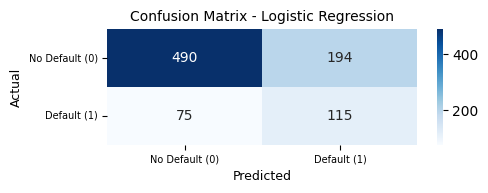

In [21]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5, 1.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])

plt.xlabel("Predicted", fontsize=9)
plt.ylabel("Actual", fontsize=9)
plt.title("Confusion Matrix - Logistic Regression", fontsize=10)

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.show()


In [34]:
# Using Random Forest to evaluate
rf_pipeline = ImbPipeline(steps=[
    ("smote", SMOTE(sampling_strategy=0.8, random_state=42)),
    ("classifier", RandomForestClassifier(n_estimators=300, max_depth=12, class_weight={0:0.15, 1:0.85}, random_state=42))
])

rf_pipeline.fit(X_train_final, y_train)
y_proba_rf = rf_pipeline.predict_proba(X_test_final)[:,1]
y_pred_rf = (y_proba_rf >= 0.54).astype(int)

print(f"Random Forest Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))

Random Forest Results:
Confusion Matrix:
 [[427 257]
 [ 73 117]]
              precision    recall  f1-score   support

           0       0.85      0.62      0.72       684
           1       0.31      0.62      0.41       190

    accuracy                           0.62       874
   macro avg       0.58      0.62      0.57       874
weighted avg       0.74      0.62      0.65       874

ROC-AUC: 0.6200292397660818


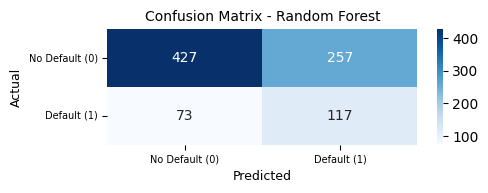

In [26]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5, 1.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])

plt.xlabel("Predicted", fontsize=9)
plt.ylabel("Actual", fontsize=9)
plt.title("Confusion Matrix - Random Forest", fontsize=10)

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.show()


In [25]:
# Using XGBoost to evaluate

xgb_pipeline = ImbPipeline(steps=[
    ("smote", SMOTE(sampling_strategy=0.95, random_state=42)),
    ("classifier", XGBClassifier(
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]), # handles imbalance
        use_label_encoder=False,
        eval_metric="logloss",
        verbosity=0,    # suppress training logs
        random_state=42
    ))
])

xgb_pipeline.fit(X_train_final, y_train)

y_proba_xgb = xgb_pipeline.predict_proba(X_test_final)[:,1]
y_pred_xgb = (y_proba_xgb >= 0.33).astype(int)

print(f"XGBoost Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_xgb))


XGBoost Results:
Confusion Matrix:
 [[427 257]
 [ 78 112]]
              precision    recall  f1-score   support

           0       0.85      0.62      0.72       684
           1       0.30      0.59      0.40       190

    accuracy                           0.62       874
   macro avg       0.57      0.61      0.56       874
weighted avg       0.73      0.62      0.65       874

ROC-AUC: 0.6068713450292398


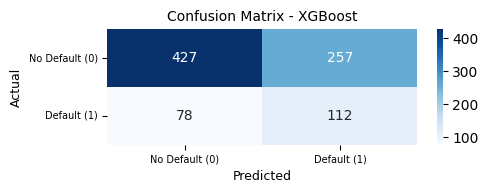

In [27]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(5, 1.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])

plt.xlabel("Predicted", fontsize=9)
plt.ylabel("Actual", fontsize=9)
plt.title("Confusion Matrix - XGBoost", fontsize=10)

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.show()


In [28]:
# Using LGBM to evaluate

lgbm_pipeline = ImbPipeline(steps=[
    ("smote", SMOTE(sampling_strategy=0.6, random_state=42)),
    ("classifier", LGBMClassifier(
        class_weight={0:0.15, 1:0.85},
        verbose=0,   # -1 = silence all logs
        random_state=42
    ))
])

lgbm_pipeline.fit(X_train_final, y_train)

y_proba_lgbm = lgbm_pipeline.predict_proba(X_test_final)[:,1]
y_pred_lgbm = (y_proba_lgbm >= 0.56).astype(int)

print(f"LGBM Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_lgbm))

LGBM Results:
Confusion Matrix:
 [[481 203]
 [ 82 108]]
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       684
           1       0.35      0.57      0.43       190

    accuracy                           0.67       874
   macro avg       0.60      0.64      0.60       874
weighted avg       0.74      0.67      0.70       874

ROC-AUC: 0.6358187134502924


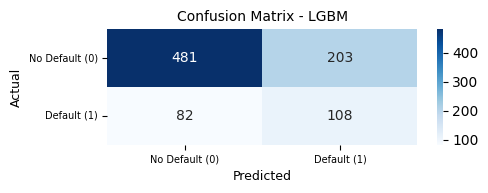

In [29]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(5, 1.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])

plt.xlabel("Predicted", fontsize=9)
plt.ylabel("Actual", fontsize=9)
plt.title("Confusion Matrix - LGBM", fontsize=10)

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.show()


In [30]:
# Using CatBoost to evaluate

catboost_pipeline = ImbPipeline(steps=[
    ("smote", SMOTE(sampling_strategy=0.58, random_state=42)),
    ("classifier", CatBoostClassifier(
        class_weights={0:0.15, 1:0.85}, #[y_train.value_counts()[0]/len(y_train), y_train.value_counts()[1]/len(y_train)],
        verbose=0,
        random_state=42
    ))
])

catboost_pipeline.fit(X_train_final, y_train)

y_proba_cat = catboost_pipeline.predict_proba(X_test_final)[:, 1]
y_pred_cat = (y_proba_cat >= 0.62).astype(int)

print(f"CatBoost Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_cat))


CatBoost Results:
Confusion Matrix:
 [[477 207]
 [ 78 112]]
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       684
           1       0.35      0.59      0.44       190

    accuracy                           0.67       874
   macro avg       0.61      0.64      0.61       874
weighted avg       0.75      0.67      0.70       874

ROC-AUC: 0.643421052631579


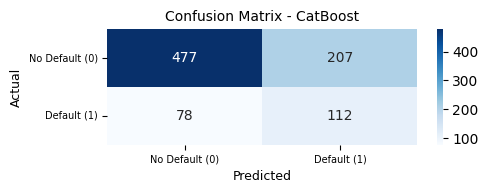

In [31]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_cat)

plt.figure(figsize=(5, 1.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])

plt.xlabel("Predicted", fontsize=9)
plt.ylabel("Actual", fontsize=9)
plt.title("Confusion Matrix - CatBoost", fontsize=10)

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.show()


##### **ROC-AUC Curve Comparison**

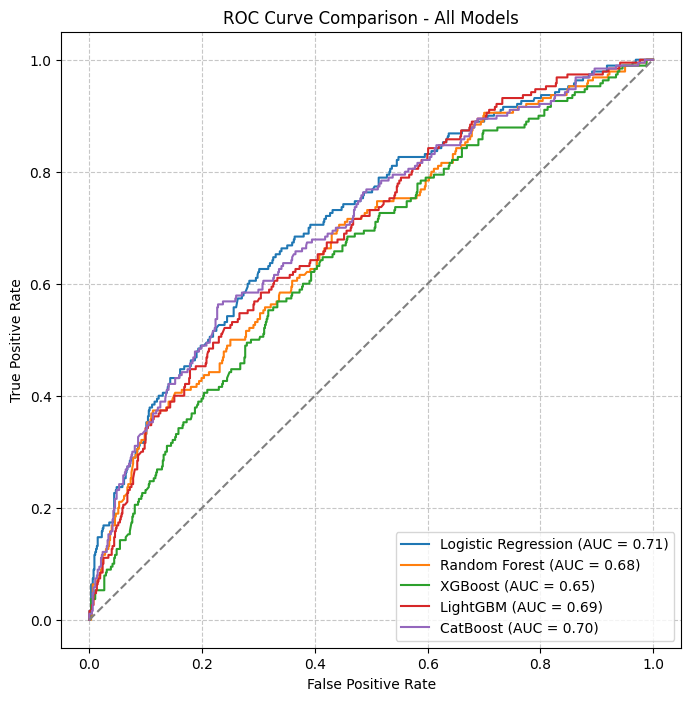

In [32]:
# Collect model names and their predicted probabilities
model_probs = {
    "Logistic Regression": y_proba_lr,
    "Random Forest": y_proba_rf,
    "XGBoost": y_proba_xgb,
    "LightGBM": y_proba_lgbm,
    "CatBoost": y_proba_cat
}

plt.figure(figsize=(8,8))

for name, y_proba in model_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

# Diagonal baseline
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison - All Models")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


#### **Voting Prediction from the 5 Fine-Tuned Models**

In [35]:
models = [lr_pipeline, rf_pipeline, xgb_pipeline, lgbm_pipeline, catboost_pipeline]
model_names = ["Logistic Regression", "Random Forest", "XGBoost", "LightGBM", "CatBoost"]

thresholds = {
    "Logistic Regression": 0.81,
    "Random Forest": 0.54,
    "XGBoost": 0.33,
    "LightGBM": 0.56,
    "CatBoost": 0.62
}


def evaluate_voting(models, model_names, thresholds, X, y=None):
    """
    Majority voting ensemble with custom thresholds for each model.
    Works for both test sets and single-sample predictions.
    
    Args:
        models: list of trained models/pipelines
        model_names: list of model names
        thresholds: dict of thresholds per model
        X: array-like, shape (n_samples, n_features) or (1, n_features)
        y: ground truth labels (optional, only needed for metrics)
    """
    all_preds = []

    for model, name in zip(models, model_names):
        y_proba = model.predict_proba(X)[:, 1]
        thresh = thresholds.get(name, 0.5)
        y_pred = (y_proba >= thresh).astype(int)
        all_preds.append(y_pred)

    all_preds = np.array(all_preds)  # shape: (n_models, n_samples)

    # Majority voting (0 vs 1)
    votes_for_1 = np.sum(all_preds, axis=0)
    votes_for_0 = all_preds.shape[0] - votes_for_1

    y_pred_final = np.where(votes_for_1 >= votes_for_0, 1, 0)

    # Confidence = fraction of votes for the winning class
    confidence = np.where(
        y_pred_final == 1,
        votes_for_1 / all_preds.shape[0],
        votes_for_0 / all_preds.shape[0]
    )

    if y is not None:  # full evaluation mode
        cm = confusion_matrix(y, y_pred_final)
        cr = classification_report(y, y_pred_final)
        roc_auc = roc_auc_score(y, y_pred_final)

        print("Confusion Matrix:\n", cm)
        print("\nClassification Report:\n", cr)
        print("ROC-AUC Score:", roc_auc)

    return y_pred_final, confidence


- **X_Test Prediction**

In [36]:
y_pred, conf = evaluate_voting(models, model_names, thresholds, X_test_final, y_test)


Confusion Matrix:
 [[480 204]
 [ 84 106]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.70      0.77       684
           1       0.34      0.56      0.42       190

    accuracy                           0.67       874
   macro avg       0.60      0.63      0.60       874
weighted avg       0.74      0.67      0.69       874

ROC-AUC Score: 0.6298245614035087


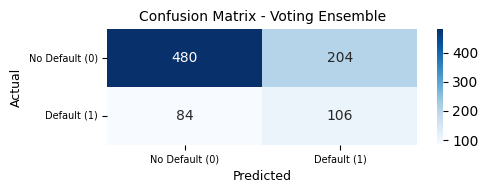

In [37]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 1.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])

plt.xlabel("Predicted", fontsize=9)
plt.ylabel("Actual", fontsize=9)
plt.title("Confusion Matrix - Voting Ensemble", fontsize=10)

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.show()


- **Single Sample Prediction**

In [73]:
# Pick one sample (e.g., the 2nd row in X_test_final)
sample = X_test_final.iloc[10].values.reshape(1, -1)
print("Sample features:\n", sample)

# Run the voting evaluation without y_test
y_pred_single, conf_single = evaluate_voting(models, model_names, thresholds, sample)

print("Prediction:", y_pred_single[0])
print("Confidence:", conf_single[0]*100, "%")


Sample features:
 [[ 1.05526991 -0.68458798 -1.5070136   1.06781526  0.20677966  0.15451761
  -0.69408565  0.20677966  0.20677966 -0.60211723 -0.6354503   0.29143004
  -0.72900921 -0.07005013  0.23943662 -0.59821308 -0.62781719 -0.4117787
  -0.31300901 -0.70104118  2.        ]]
Prediction: 1
Confidence: 100.0 %


In [60]:
# Pick one sample (e.g., the 2nd row in X_test_final)
sample = X_test_final.iloc[200].values.reshape(1, -1)

# Run the voting evaluation without y_test
y_pred_single, conf_single = evaluate_voting(models, model_names, thresholds, sample)

print("Prediction:", y_pred_single[0])
print("Confidence:", conf_single[0]*100, "%")

Prediction: 0
Confidence: 60.0 %


<br>

#### **Save Models to Pickle Files**

In [71]:
# Save the preprocessiing pipelines

import joblib

os.makedirs("streamlit/models", exist_ok=True)

# Save actual objects, not their names
joblib.dump(preprocessor, "streamlit/models/preprocessor.pkl")
joblib.dump(risk_cluster, "streamlit/models/risk_cluster.pkl")

print("✅ Preprocessor and Risk Cluster saved successfully")

✅ Preprocessor and Risk Cluster saved successfully


In [ ]:
# Save final trained models

# Ensure folder exists
os.makedirs("streamlit", exist_ok=True)

models = [lr_pipeline, rf_pipeline, xgb_pipeline, lgbm_pipeline, catboost_pipeline]
model_names = ["Logistic Regression", "Random Forest", "XGBoost", "LightGBM", "CatBoost"]

for model, name in zip(models, model_names):
    filename = os.path.join("streamlit", f"{name.replace(' ', '_')}.pkl")
#    with open(filename, "wb") as f:
#        pickle.dump(model, f)
    print(f"✅ Saved {name} to {filename}")


✅ Saved Logistic Regression to streamlit\Logistic_Regression.pkl
✅ Saved Random Forest to streamlit\Random_Forest.pkl
✅ Saved XGBoost to streamlit\XGBoost.pkl
✅ Saved LightGBM to streamlit\LightGBM.pkl
✅ Saved CatBoost to streamlit\CatBoost.pkl


In [ ]:
# Voting ensemble components

import cloudpickle

os.makedirs("streamlit/models", exist_ok=True)

models = [lr_pipeline, rf_pipeline, xgb_pipeline, lgbm_pipeline, catboost_pipeline]
model_names = ["Logistic Regression", "Random Forest", "XGBoost", "LightGBM", "CatBoost"]

thresholds = {
    "Logistic Regression": 0.81,
    "Random Forest": 0.54,
    "XGBoost": 0.33,
    "LightGBM": 0.56,
    "CatBoost": 0.62
}

# Package everything needed for voting
vote_package = {
    "models": models,
    "model_names": model_names,
    "thresholds": thresholds,
    "voting_function": evaluate_voting
}

# Save to pickle
vote_filename = os.path.join("streamlit/models", "Vote.pkl")
# with open(vote_filename, "wb") as f:
#     cloudpickle.dump(vote_package, f)

print(f"✅ Voting package saved to {vote_filename}")

✅ Voting package saved to streamlit/models\Vote.pkl


<br>

### **Neural Network Model**

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# ==============================
# Train/Validation split
# ==============================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_final, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Convert to tensors
X_train_tensor = torch.tensor(X_tr.to_numpy().astype(np.float32))
y_train_tensor = torch.tensor(y_tr.to_numpy().astype(np.float32)).view(-1, 1)
X_val_tensor = torch.tensor(X_val.to_numpy().astype(np.float32))
y_val_tensor = torch.tensor(y_val.to_numpy().astype(np.float32)).view(-1, 1)

# Create Datasets & Loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=False)

# ==============================
# Define DNN model
# ==============================
class DefaultClassifier(nn.Module):
    def __init__(self, input_dim):
        super(DefaultClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 1)  # raw logits
        )

    def forward(self, x):
        return self.fc(x)


# Initialize model
input_dim = X_train_final.shape[1]
model = DefaultClassifier(input_dim)

# ==============================
# Loss and optimizer
# ==============================
pos_weight = torch.tensor([(len(y_tr) - sum(y_tr)) / sum(y_tr)])  # balance for class imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# ==============================
# Training loop
# ==============================
epochs = 30
for epoch in range(epochs):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss = 0
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)  # convert logits → probability
            preds = (probs > 0.5).float()

            all_probs.extend(probs.numpy())
            all_preds.extend(preds.numpy())
            all_labels.extend(batch_y.numpy())

    val_loss /= len(val_loader)
    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Acc: {acc:.4f}, Val AUC: {auc:.4f}")


Epoch [1/30] Train Loss: 1.0194, Val Loss: 1.0149, Val Acc: 0.6953, Val AUC: 0.6793
Epoch [2/30] Train Loss: 0.9855, Val Loss: 1.0159, Val Acc: 0.7182, Val AUC: 0.6677
Epoch [3/30] Train Loss: 0.9802, Val Loss: 1.0017, Val Acc: 0.6867, Val AUC: 0.6888
Epoch [4/30] Train Loss: 0.9740, Val Loss: 1.0209, Val Acc: 0.7153, Val AUC: 0.6729
Epoch [5/30] Train Loss: 0.9654, Val Loss: 0.9884, Val Acc: 0.6767, Val AUC: 0.7043
Epoch [6/30] Train Loss: 0.9641, Val Loss: 0.9980, Val Acc: 0.6810, Val AUC: 0.7000
Epoch [7/30] Train Loss: 0.9583, Val Loss: 0.9991, Val Acc: 0.6896, Val AUC: 0.6944
Epoch [8/30] Train Loss: 0.9499, Val Loss: 1.0099, Val Acc: 0.6638, Val AUC: 0.6924
Epoch [9/30] Train Loss: 0.9712, Val Loss: 1.0052, Val Acc: 0.6867, Val AUC: 0.6892
Epoch [10/30] Train Loss: 0.9442, Val Loss: 1.0182, Val Acc: 0.6881, Val AUC: 0.6765
Epoch [11/30] Train Loss: 0.9455, Val Loss: 1.0199, Val Acc: 0.6953, Val AUC: 0.6858
Epoch [12/30] Train Loss: 0.9412, Val Loss: 1.0220, Val Acc: 0.6767, Val A

In [55]:
from sklearn.metrics import confusion_matrix, classification_report

# ==============================
# Test on X_test_final with labels
# ==============================
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_final.to_numpy().astype(np.float32))
    y_test_tensor = torch.tensor(y_test.to_numpy().astype(np.float32)).view(-1, 1)

    outputs = model(X_test_tensor)
    probs = torch.sigmoid(outputs).numpy().flatten()
    preds = (probs > 0.45).astype(int)

# Metrics
acc_test = accuracy_score(y_test_tensor.numpy(), preds)
auc_test = roc_auc_score(y_test_tensor.numpy(), probs)
cm = confusion_matrix(y_test_tensor.numpy(), preds)
report = classification_report(y_test_tensor.numpy(), preds, digits=4)

print(f"Final Evaluation on Test Set -> Acc: {acc_test:.4f}, AUC: {auc_test:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


Final Evaluation on Test Set -> Acc: 0.6327, AUC: 0.6678

Confusion Matrix:
 [[432 252]
 [ 69 121]]

Classification Report:
               precision    recall  f1-score   support

         0.0     0.8623    0.6316    0.7291       684
         1.0     0.3244    0.6368    0.4298       190

    accuracy                         0.6327       874
   macro avg     0.5933    0.6342    0.5795       874
weighted avg     0.7453    0.6327    0.6641       874



In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(5, 1.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])

plt.xlabel("Predicted", fontsize=9)
plt.ylabel("Actual", fontsize=9)
plt.title("Confusion Matrix - Voting Ensemble", fontsize=10)

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.show()